In [48]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # Adam is just like SGD but faster
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import seaborn as sns  # Import Seaborn for the heatmap
import threading
import concurrent.futures
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import os
from collections import namedtuple
from sklearn.metrics import classification_report
from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# Helper Functions

In [6]:
def print_df_with_all_rows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

def print_df_with_all_cols(df):
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_columns')
    
def print_all_df(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

def summary_a_df(df):
    # Summary statistics for numerical columns
    numerical_summary = df.describe()

    # Summary statistics for string columns
    string_summary = df.describe(include=['object'])

    # Combine the summaries
    summary = pd.concat([numerical_summary, string_summary], axis=1)

    # Display the summary in table-like format
    display(summary.style.set_caption("Summary Statistics"))
    
def remove_nan_and_inf(df):
    df = df.dropna(how='any', axis=0, inplace=False)
    inf_condition = (df == np.inf).any(axis=1)
    df = df[~inf_condition]
    return df

def count_labels(df):
    label_counts = df[' Label'].value_counts()

    # Convert the value counts into a DataFrame for better formatting
    label_counts_df = pd.DataFrame(label_counts)

    # Rename the column to make it more descriptive
    label_counts_df.columns = ['Count']

    # Print the table
    display(label_counts_df)
    
def label_coding(df, label):
    label_encoder = LabelEncoder()
    df[label] = label_encoder.fit_transform(df[label])
    return df

# Make csv File Training and Test set

In [28]:
# Define a named tuple to represent the return type
TrainTestSplit = namedtuple('TrainTestSplit', 
                            ['X_train', 'X_test', 'y_train', 'y_test', 'categories_as_list'])
def get_train_and_test(dfs):
    data = pd.concat(dfs, ignore_index=True)
    data = remove_nan_and_inf(data)
    
    # summary_a_df(data)
    
    # drop some unused feature
    data = data.drop(columns='Flow ID')

    # do label encoding to some feature
    label_encoder = LabelEncoder()
    data[" Source IP"] = label_encoder.fit_transform(data[" Source IP"])
    data[" Source Port"] = label_encoder.fit_transform(data[" Source Port"])
    data[" Destination IP"] = label_encoder.fit_transform(data[" Destination IP"])
    data[" Destination Port"] = label_encoder.fit_transform(data[" Destination Port"])
    data[" Timestamp"] = label_encoder.fit_transform(data[" Timestamp"])

    # Shuffle all the rows of the DataFrame
    # data = data.sample(frac=1).reset_index(drop=True)
    # summary_a_df(data)
    
    ### get `X` from `data`
    X = data.drop(columns=' Label')
    X = X.values.reshape(-1, X.shape[1]).astype('float32')
    standardizer = preprocessing.StandardScaler()
    X = standardizer.fit_transform(X)
    
    ### get `y` from `data`
    y = data.iloc[:, -1:]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    categories = ohe.categories_
    categories_as_list = []
    for i, label in enumerate(categories[0]):
        categories_as_list.append(label)
        
    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float32).to(DEVICE)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, shuffle=True)
    return TrainTestSplit(X_train, X_test, y_train, y_test, categories_as_list)

In [22]:
dataset_dir = './TrafficLabelling/'
def read_csv(csv_file):
    file_path = os.path.join(dataset_dir, csv_file)
    # Try different encodings until the file is successfully read
    df = None
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'windows-1252']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            break  # Stop trying encodings once the file is successfully read
        except UnicodeDecodeError:
            continue
    return df
    
df_Mon  = read_csv("Monday-WorkingHours.pcap_ISCX.csv")
df_Tue  = read_csv("Tuesday-WorkingHours.pcap_ISCX.csv")
df_Wed  = read_csv("Wednesday-workingHours.pcap_ISCX.csv")
df_Thu1 = read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_Thu2 = read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_Fri1 = read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_Fri2 = read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_Fri3 = read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv")

/tmp/ipykernel_2161648/1221332360.py:8: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding)


# Function for Training Models

In [55]:
def training_model(model, 
                   train_test,
                   learning_rate, n_epochs, batch_size):
    # get data from train_test
    X_train            = train_test.X_train           
    X_test             = train_test.X_test            
    y_train            = train_test.y_train           
    y_test             = train_test.y_test            
    categories_as_list = train_test.categories_as_list
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # prepare model and training parameters
    batches_per_epoch = len(X_train) // batch_size

    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    # start training 
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        # set model in training mode and run through each batch
        model.train()
        with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
            bar.set_description(f"Epoch {epoch}")
            for i in bar:
                # take a batch
                start = i * batch_size
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]

                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)

                # backward pass
                optimizer.zero_grad()
                loss.backward()

                # update weights
                optimizer.step()

                # compute and store metrics
                acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
                epoch_loss.append(float(loss))
                epoch_acc.append(float(acc))
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # set model in evaluation mode and run through the test set
        model.eval()
        y_pred = model(X_test)
        ce = loss_fn(y_pred, y_test)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        test_loss_hist.append(ce)
        test_acc_hist.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")
        
    # display result
    # Restore best model
    model.load_state_dict(best_weights)

    # Plot the loss and accuracy
    plt.plot(train_loss_hist, label="train")
    plt.plot(test_loss_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("cross entropy")
    plt.legend()
    # plt.savefig('cross_entropy.png')
    plt.show()

    plt.plot(train_acc_hist, label="train")
    plt.plot(test_acc_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    # plt.savefig('accuracy.png')
    plt.show()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    y_pred_classes = torch.argmax(y_pred, dim=1).cpu().numpy()
    y_true_classes = torch.argmax(y_test, dim=1).cpu().numpy()

    from sklearn.metrics import confusion_matrix

    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Assuming you have already computed the confusion matrix
    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Define your custom class labels
    # class_labels = ['normal', 'tcpfin', 'tcppush', 'tcprst', 'tcpsyn', 'udpflood']
    class_labels = categories_as_list
    # class_labels = [i for i in range(1, 16)]
    # Create a heatmap of the confusion matrix with custom labels
    # categories_as_list = [item for sublist in categories for item in sublist]  # Flatten the categories list
    # class_labels = categories_as_list

    plt.figure(figsize=(16, 12))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Calculate the classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)


In [61]:
# Mon = get_train_and_test([df_Mon])
Tue = get_train_and_test([df_Tue])
Wen = get_train_and_test([df_Wed])
Thu = get_train_and_test([df_Thu1, df_Thu2])

# Defining models

In [63]:
class ANN(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        self.hidden1 = nn.Linear(83, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, num_outputs)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x
ann_Tue = ANN(num_outputs=len(Tue.categories_as_list)).to(DEVICE)

Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 583/583 [00:00<00:00, 697.26batch/s, acc=1, loss=0.00216]


Epoch 0 validation: Cross-entropy=0.00, Accuracy=100.0%


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████| 583/583 [00:00<00:00, 793.77batch/s, acc=1, loss=0.000459]


Epoch 1 validation: Cross-entropy=0.00, Accuracy=100.0%


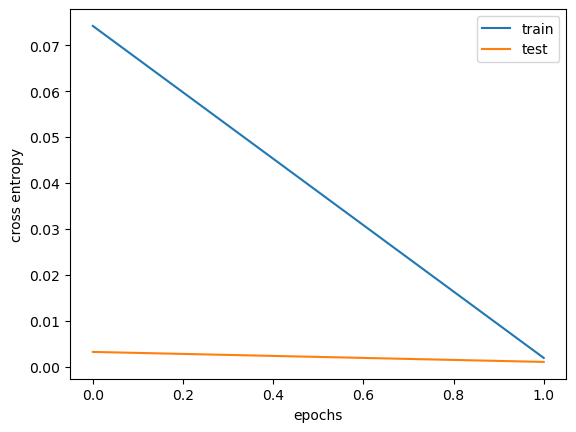

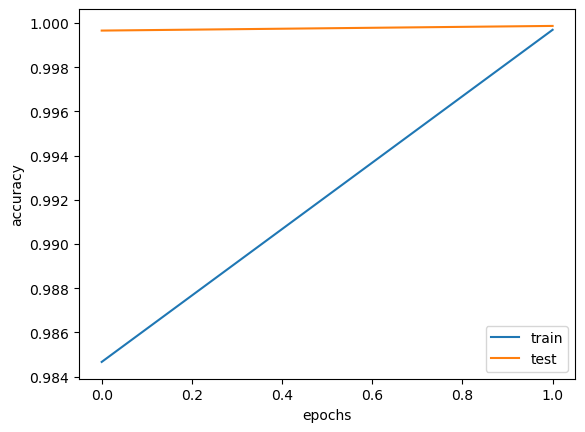

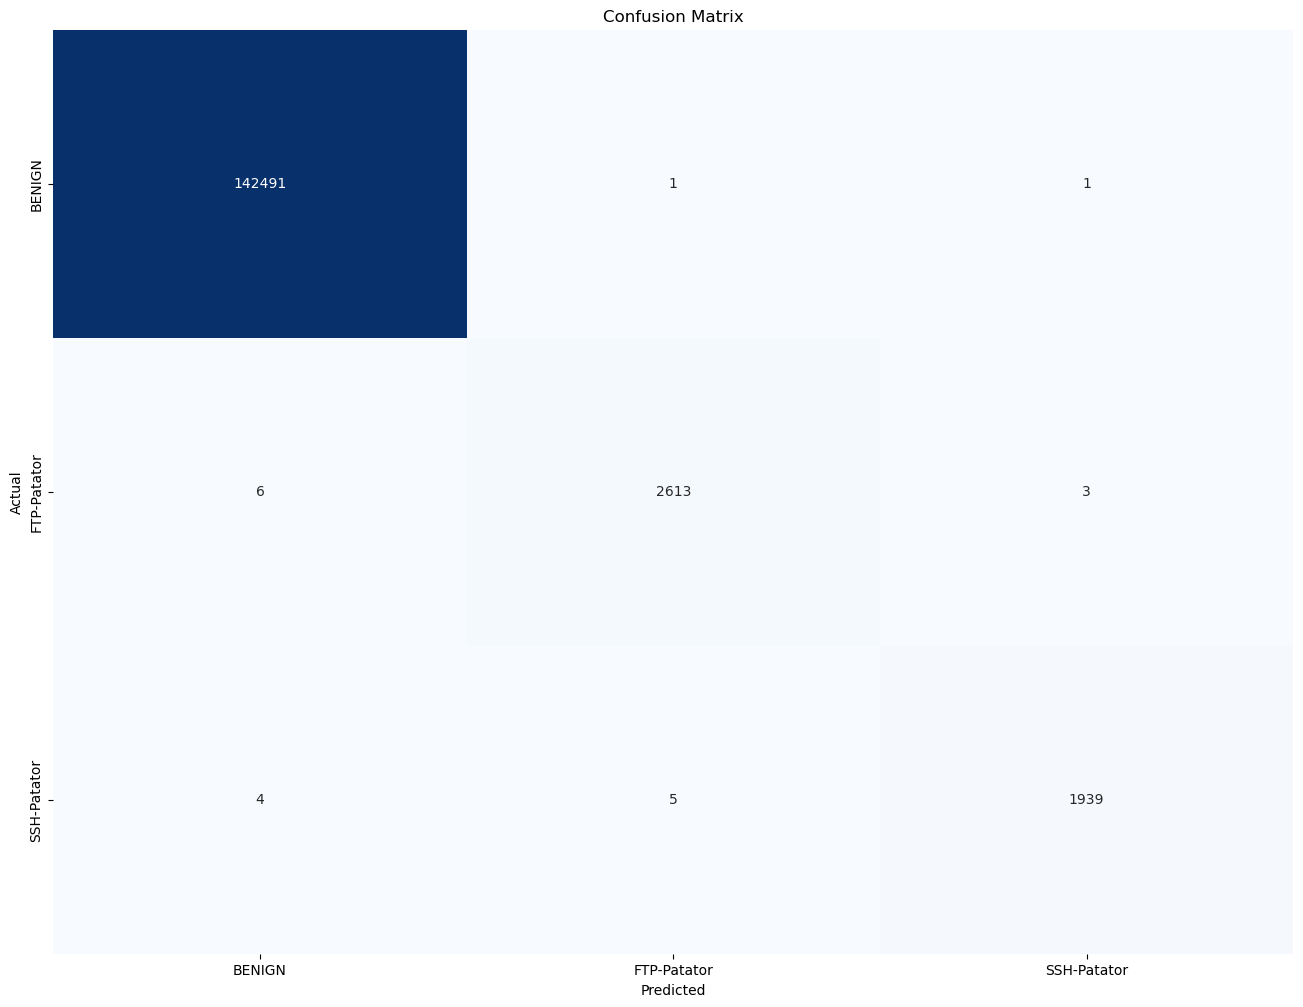

,precision,recall,f1-score,support
BENIGN,0.999930,0.999986,0.999958,142493.000000
FTP-Patator,0.997709,0.996568,0.997138,2622.000000
SSH-Patator,0.997941,0.995380,0.996659,1948.000000
accuracy,0.999864,0.999864,0.999864,0.999864
macro avg,0.998527,0.997311,0.997918,147063.000000
weighted avg,0.999864,0.999864,0.999864,147063.000000


In [66]:
# training_model(model=ann, 
#                train_test=Mon,
#                learning_rate=0.001, n_epochs=2, batch_size=512)
training_model(model=ann_Tue, 
               train_test=Tue,
               learning_rate=0.001, n_epochs=2, batch_size=512)